### Chicken Weights - Don't Be Scared

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
chicken_df = pd.read_csv('chickwts_data.csv')
chicken_df.head()

,weight,feed
0,179,horsebean
1,160,horsebean
2,136,horsebean
3,227,horsebean
4,217,horsebean


Counts of each feed type:
 feed
soybean      14
linseed      12
sunflower    12
casein       12
meatmeal     11
horsebean    10
Name: count, dtype: int64


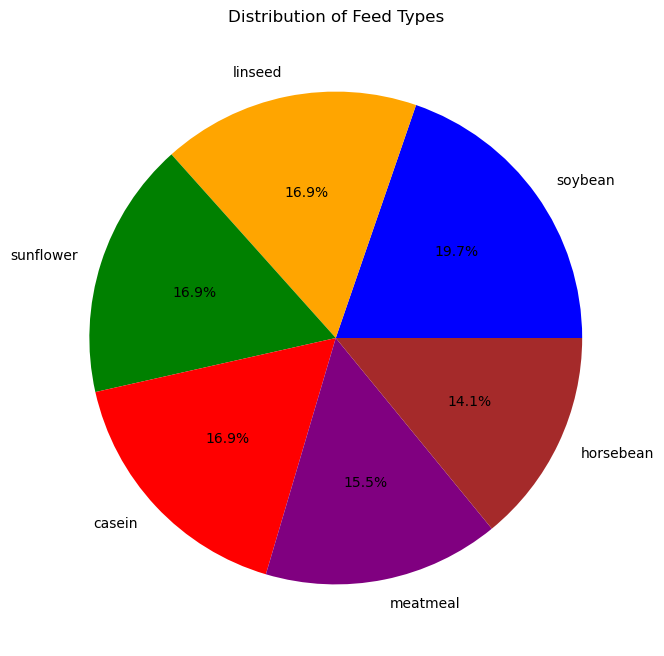

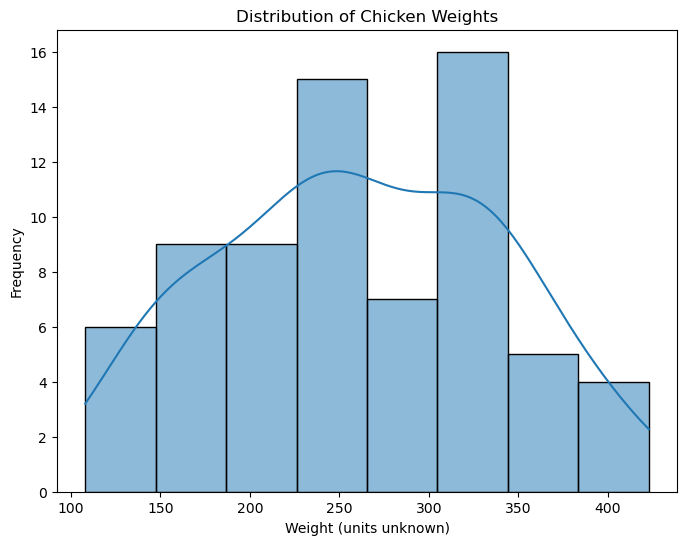

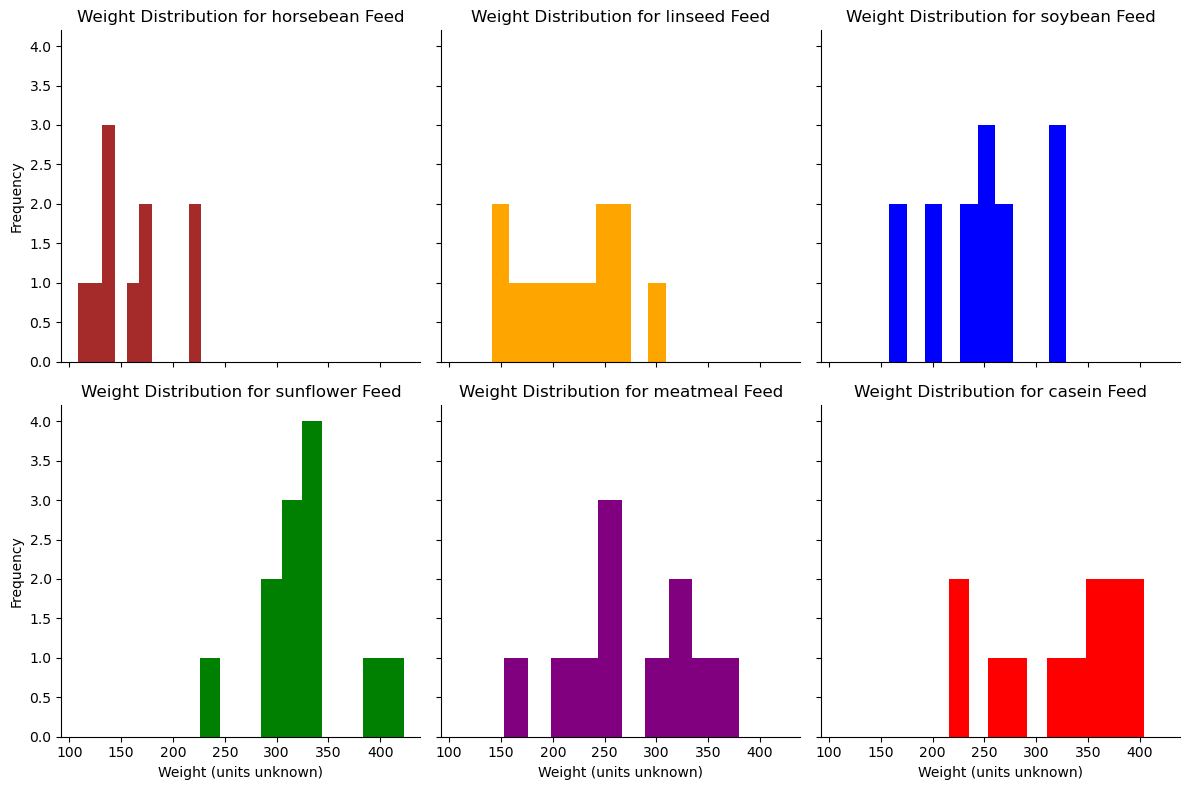

In [3]:
feed_counts = chicken_df['feed'].value_counts()
print("Counts of each feed type:\n", feed_counts)

# Define a consistent color map to use throughout
feed_colors = {
    "soybean": "blue",
    "linseed": "orange",
    "sunflower": "green",
    "casein": "red",
    "meatmeal": "purple",
    "horsebean": "brown"
}
# Feed types pie chart
plt.figure(figsize=(8, 8))
plt.pie(feed_counts, labels=feed_counts.index, colors=[feed_colors[feed] for feed in feed_counts.index], autopct='%1.1f%%')
plt.title('Distribution of Feed Types')
plt.show()

# Weight distribution
plt.figure(figsize=(8, 6))
sns.histplot(chicken_df['weight'], kde=True)
plt.title('Distribution of Chicken Weights')
plt.xlabel('Weight (units unknown)')
plt.ylabel('Frequency')
plt.show()

# Weight distribution by feed type
g = sns.FacetGrid(chicken_df, col='feed', col_wrap=3, height=4)
for ax, feed in zip(g.axes.flat, chicken_df['feed'].unique()):
    data = chicken_df[chicken_df['feed'] == feed]
    ax.hist(data['weight'], color=feed_colors[feed])
    ax.set_title(f"Weight Distribution for {feed} Feed")
    ax.set_xlabel("Weight (units unknown)")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

#### EDA Analysis

The data set is tiny with only two columns, weight and feed type. There are no missing values or impossible values (negative weights) or obvious outliers.

The units of measure are unclear. Based on the distributions it seems most likely that the weights are in grams and represent younger/developing chickens, but it is possible that they are in ounces representing very large chickens. 

Each feed type is represented more or less equally.

#### Feed Type Analysis (Gemini)

 - soybean: Soybean meal is a very common and high-protein feed source for poultry. It's generally considered a good quality feed that supports healthy growth.

 - linseed: Linseed meal, derived from flax seeds, is another protein-rich feed. It's also known for its omega-3 fatty acid content, which can potentially influence the nutritional profile of the chicken meat and eggs.

 - sunflower: Sunflower meal is a byproduct of sunflower oil production. It provides protein and fiber. The protein content can vary depending on the processing method.

 - casein: Casein is a milk protein. It's often used in research diets for animals due to its consistent protein quality. In typical commercial poultry farming, it's less common due to cost.

 - meatmeal: Meatmeal is a rendered product from animal tissues. It's a source of protein and minerals. The quality and composition can vary depending on the source materials.

 - horsebean: Horsebeans, also known as fava beans, are legumes. They can be used as a protein source in animal feed. However, some varieties contain vicine and convicine, compounds that can cause favism in humans and potentially lead to health issues in poultry if fed in high quantities or if the specific variety is susceptible. This might be something to keep in mind when analyzing the weights associated with this feed type.

 #### PCA

In [4]:
feed_dummies = pd.get_dummies(chicken_df['feed'], prefix='feed', drop_first=True)
data_for_pca = pd.concat([chicken_df['weight'], feed_dummies], axis=1)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_pca)

pca = PCA(n_components=1)
principal_components = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(data=principal_components, columns=['principal_component_1'])

chicken_pca_df = pd.concat([chicken_df, pca_df], axis=1)

print("\nExplained variance:", pca.explained_variance_ratio_)
data_for_pca.head()


Explained variance: [0.30038427]


,weight,feed_horsebean,feed_linseed,feed_meatmeal,feed_soybean,feed_sunflower
0,179,True,False,False,False,False
1,160,True,False,False,False,False
2,136,True,False,False,False,False
3,227,True,False,False,False,False
4,217,True,False,False,False,False


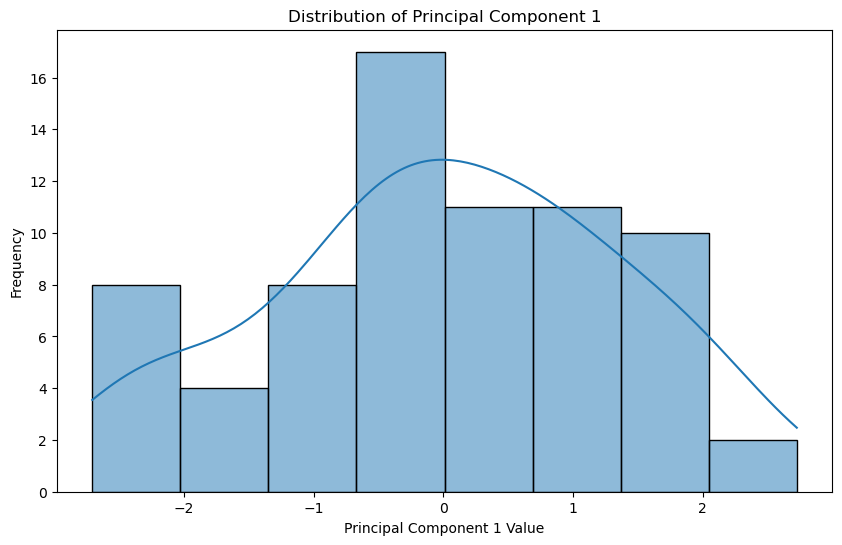

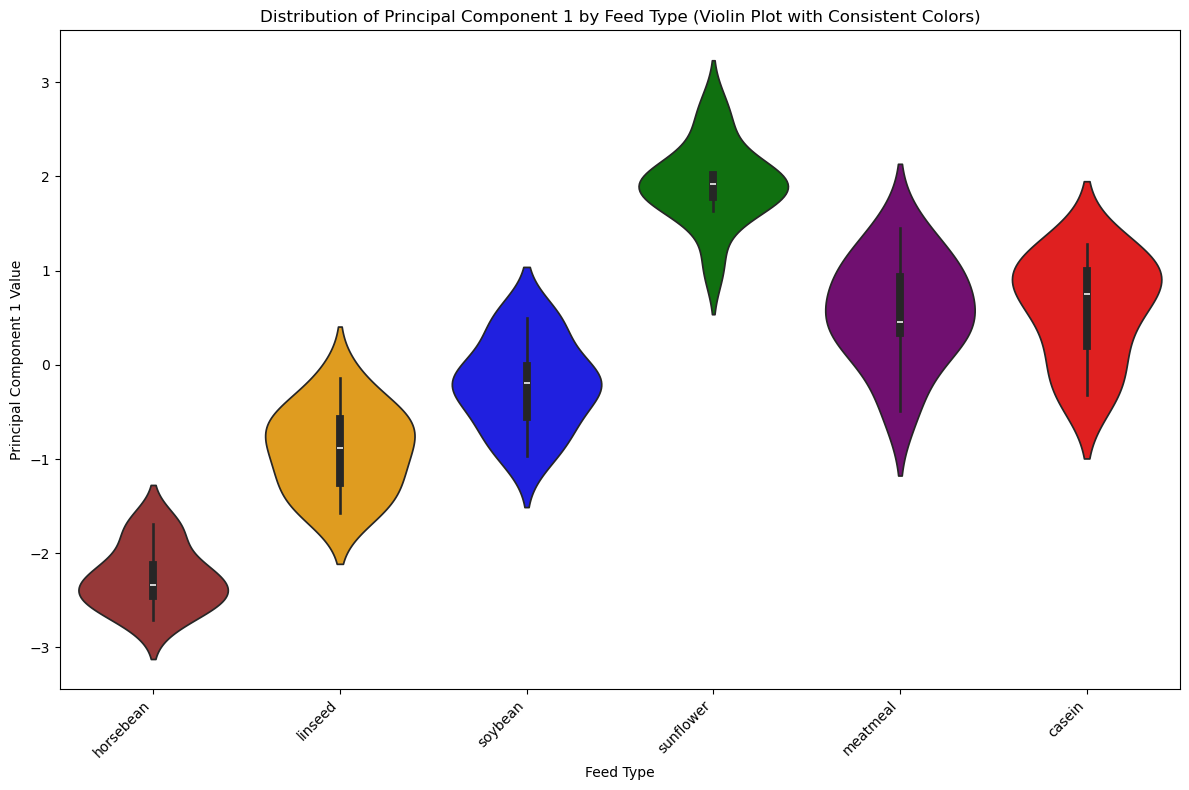

In [5]:
# PCA Distributiuon
plt.figure(figsize=(10, 6))
sns.histplot(chicken_pca_df['principal_component_1'], kde=True)
plt.title('Distribution of Principal Component 1')
plt.xlabel('Principal Component 1 Value')
plt.ylabel('Frequency')
plt.show()

# PCA Distribution by feed type (violin plot)
plt.figure(figsize=(12, 8))
sns.violinplot(x='feed', y='principal_component_1', data=chicken_pca_df,
                palette=feed_colors, hue='feed', legend=False)
plt.title('Distribution of Principal Component 1 by Feed Type (Violin Plot with Consistent Colors)')
plt.xlabel('Feed Type')
plt.ylabel('Principal Component 1 Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Analysis of PCA Results

**Visual** - Meatmeal and casein seem the most similar, with linseed and soybean also close. Sunflower and horsebean both show different distributions. This matches up with the simpler histograms above showing weight distribution by feed type.

**Value** - To reduce a data set that was already effectively one-dimensional, we've sacrificed 70% of the explained variability. This does not seem to be an effective usage of the technique.

In [6]:
average_pca_by_feed = chicken_pca_df.groupby('feed')['principal_component_1'].mean().reset_index()
average_pca_by_feed = average_pca_by_feed.rename(columns={'principal_component_1': 'average_pc1'})

feed_types = average_pca_by_feed['feed'].tolist()
average_pc1_values = average_pca_by_feed['average_pc1'].values.reshape(-1, 1)

cosine_sim_matrix = cosine_similarity(average_pc1_values)

# DF to display
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=feed_types, columns=feed_types)

print("Cosine Similarity Matrix between Feed Types (PCA)")
cosine_sim_df

Cosine Similarity Matrix between Feed Types (PCA)


,casein,horsebean,linseed,meatmeal,soybean,sunflower
casein,1.0,-1.0,-1.0,1.0,-1.0,1.0
horsebean,-1.0,1.0,1.0,-1.0,1.0,-1.0
linseed,-1.0,1.0,1.0,-1.0,1.0,-1.0
meatmeal,1.0,-1.0,-1.0,1.0,-1.0,1.0
soybean,-1.0,1.0,1.0,-1.0,1.0,-1.0
sunflower,1.0,-1.0,-1.0,1.0,-1.0,1.0


In [7]:
results = []
for feed_type in cosine_sim_df.index:
    similar_feeds = cosine_sim_df.loc[feed_type][cosine_sim_df.loc[feed_type] == 1].index.tolist()
    dissimilar_feeds = cosine_sim_df.loc[feed_type][cosine_sim_df.loc[feed_type] == -1].index.tolist()

    # Remove the identity
    if feed_type in similar_feeds:
        similar_feeds.remove(feed_type)

    results.append({
        'Feed Type': feed_type,
        'Similar Feeds (Cosine = 1)': ', '.join(similar_feeds) if similar_feeds else 'None',
        'Dissimilar Feeds (Cosine = -1)': ', '.join(dissimilar_feeds) if dissimilar_feeds else 'None'
    })

final_table_df = pd.DataFrame(results)
final_table_df

,Feed Type,Similar Feeds (Cosine = 1),Dissimilar Feeds (Cosine = -1)
0,casein,"meatmeal, sunflower","horsebean, linseed, soybean"
1,horsebean,"linseed, soybean","casein, meatmeal, sunflower"
2,linseed,"horsebean, soybean","casein, meatmeal, sunflower"
3,meatmeal,"casein, sunflower","horsebean, linseed, soybean"
4,soybean,"horsebean, linseed","casein, meatmeal, sunflower"
5,sunflower,"casein, meatmeal","horsebean, linseed, soybean"


#### Final Analysis

**"Recommendations"** - The table above shows purely based on PCA analysis of weights which feeds are most similar. For example, an operation currently using linseed could replace that with horsebean or soybean feed if desiring a similar option, or casein, meatmeal, or sunflower if desiring a change.

**Final Comment** - This analysis is highly limited by the narrowness of the data set. Presumably there are many factors other than weight that matter when deciding on feed, including price/cost information, regional distribution, possible effects on taste, and so on. 